In [1]:
%pylab inline
import numpy as np
import torch
from tqdm import trange

# needed otherwise imshow kills kernel
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('./Data_MNIST/train-images.idx3-ubyte', 'rb') as f:
    data = f.read()
    X_train = np.frombuffer(data, dtype = np.uint8)[0x10:].reshape(-1,28,28)
with open('./Data_MNIST/train-labels.idx1-ubyte', 'rb') as f:
    data = f.read()
    Y_train = np.frombuffer(data, dtype = np.uint8)[8:]

with open('./Data_MNIST/t10k-images.idx3-ubyte', 'rb') as f:
    data = f.read()
    X_test = np.frombuffer(data, dtype = np.uint8)[0x10:].reshape(-1,28,28)

with open('./Data_MNIST/t10k-labels.idx1-ubyte', 'rb') as f:
    data = f.read()
    Y_test = np.frombuffer(data, dtype = np.uint8)[8:]



7


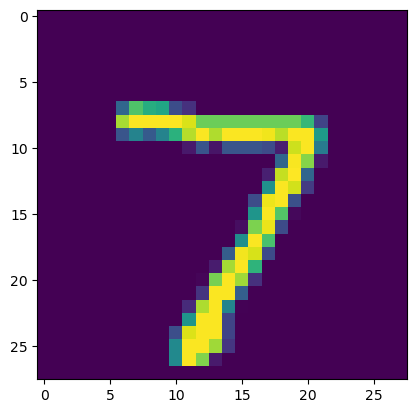

In [3]:
imshow(X_test[0,:,:])
print(Y_test[0])

# Implementation in Pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class TorchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 5,padding = 2, bias = False)
        self.conv2 = nn.Conv2d(16,32, kernel_size = 5, padding = 2, bias = False)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.ln = nn.Linear(32*7*7, 10, bias = False)
        self.logsoftmax = nn.LogSoftmax(dim = -1)
        
    def forward(self, x):
        B = x.shape[0]
        temp = self.conv1(x)
        relu = F.relu(temp)
        
        x = self.maxpool1(relu)
        relu2 = F.relu(self.conv2(x))
        x = self.maxpool2(relu2)

        x = x.view(B, -1)
        out = self.logsoftmax(self.ln(x))

        return out

Loss: 0.121, accuracy: 0.953 : 100%|███████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.30it/s]


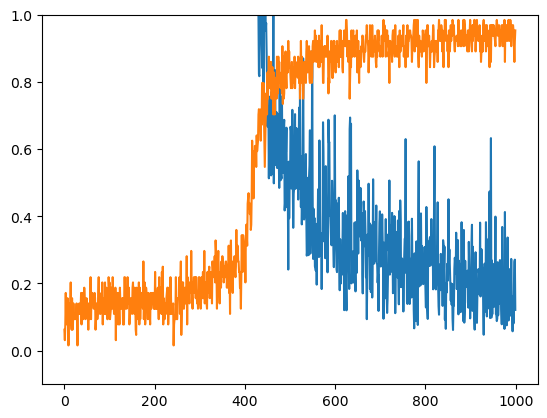

In [6]:
max_iters  = trange(1000)
model = TorchNet()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.01)
batch_size = 64

losses = []
accuracies = []

for t in max_iters:
    indx = torch.randint(X_train.shape[0], (batch_size,))
    X = torch.tensor(X_train[indx].reshape(batch_size,1,28,28), dtype = torch.float)
    Y= torch.tensor(Y_train[indx])
    
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out,dim = 1)

    accuracy = (cat == Y).float().mean()
    loss = loss_fn(out, Y)
    loss.backward()
    optim.step()

    losses.append(loss.item())
    accuracies.append(accuracy)

    max_iters.set_description("Loss: %.3f, accuracy: %.3f " % (loss.item(),accuracy))

plt.ylim(-0.1,1)
plot(losses)
plot(accuracies)

In [7]:
torch.argmax(model(torch.tensor(X_train[0].reshape(1,28,28), dtype = torch.float)))

tensor(5)

In [8]:
Y_train[0]

5

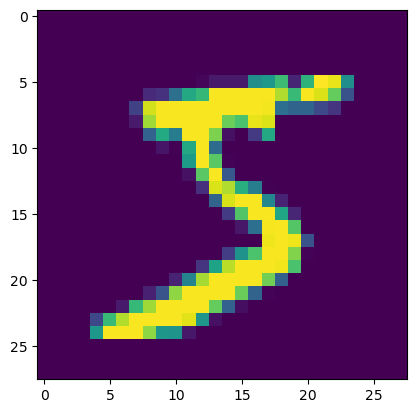

In [9]:
imshow(X_train[0])

In [10]:
with torch.no_grad():
    test_pred = model(torch.tensor(X_test.reshape(X_test.shape[0],1,28,28)).float())
    cat = torch.argmax(test_pred,dim = 1).numpy()
    
(cat == Y_test).mean()

0.9406

## Compute gradients in torch to compare later with numpy
Only plot for certain dimensions but only a simple check

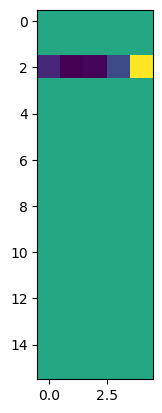

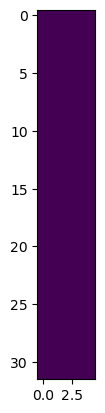

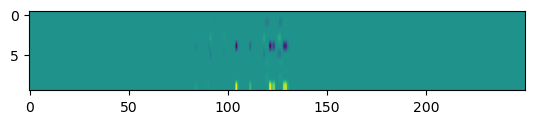

In [11]:
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_train[samp].reshape(4,1,28,28)).float())
out.retain_grad()
loss = loss_fn(out, torch.tensor(Y_train[samp]))
loss.retain_grad()
loss.backward()
imshow(model.conv1.weight.grad[:,0,:,0])
figure()
imshow(model.conv2.weight.grad[:,0,:,0])
figure()
imshow(model.ln.weight.grad[:,750:1000],aspect = 4)

# Implementation Forward Pass in numpy

In [12]:
conv1 = model.conv1.weight.detach().numpy()
conv2 = model.conv2.weight.detach().numpy()
ln = model.ln.weight.detach().numpy()
print(conv1.shape, conv2.shape, ln.shape)

(16, 1, 5, 5) (32, 16, 5, 5) (10, 1568)


In [13]:
samp = [0,1,2,3]
torch_out = model(torch.tensor(X_train[samp].reshape(4,1,28,28)).float())

In [14]:
torch_out.shape

torch.Size([4, 10])

In [63]:
def logsumexp(x):
    c = x.max(axis = 1)
    return c + np.log(np.exp(x - c.reshape((-1,1))).sum(axis = 1))

def forward_backward(x,y):
    nb_batch, c_in, h_in, w_in = x.shape
    f_out, f_in, f_h, f_w = conv1.shape
    
    l_conv1 = np.zeros((nb_batch,f_out, h_in, w_in))

    x_padded = np.pad(x, ((0,0),(0,0),(2,2),(2,2)))

    for i in range(h_in):
        for j in range(w_in):
            l_conv1[:,:,i,j] = np.sum(x_padded[:,np.newaxis,0,i:i+5,j:j+5]*conv1[np.newaxis,:,0,:,:], axis= (2,3))

    relu_conv1=np.maximum(l_conv1, 0)

    maxpooled_conv1 = relu_conv1.reshape(nb_batch, f_out, h_in//2, 2, w_in //2, 2).max(axis = (3,5))

    # Create max which position was max, used in back-propagation
    # WARNING: Case of more than one maximum the gradient will be propagated too many times, 
    # not a problem when max == 0 as we multiply with the values preceding the pooling
    mask_conv1 = (relu_conv1 == maxpooled_conv1.repeat(2, axis = 2).repeat(2,axis = 3)).astype('int')
    # Below is a better implementation taking into account this possibility but leads to slightly different result than torch
    '''
    # BY HAND: create mask from scratch to ensure we backpropagate only once for each pooling
    mask_conv1 = np.zeros(relu_conv1.shape)
    for b in range(relu_conv1.shape[0]):
        for c in range(relu_conv1.shape[1]):
            for i in range(relu_conv1.shape[2]//2):
                for j in range(relu_conv1.shape[3]//2):
                    max_val = maxpooled_conv1[b,c,i,j]
                    if max_val == relu_conv1[b,c,2*i,2*j]:
                        mask_conv1[b,c,2*i,2*j] = 1
                    elif max_val == relu_conv1[b,c,2*i,2*j+1]:
                        mask_conv1[b,c,2*i,2*j+1]=1
                    elif max_val == relu_conv1[b,c,2*i+1,2*j]:
                        mask_conv1[b,c,2*i+1,2*j]
                    else:
                        mask_conv1[b,c,2*i+1,2*j+1] = 1
    '''
  
    
    nb_batch, c_in, h_in, w_in = maxpooled_conv1.shape
    f_out, f_in, f_h, f_w = conv2.shape
    l_conv2 = np.zeros((nb_batch,f_out, h_in, w_in))

    padded_conv1 = np.pad(maxpooled_conv1, ((0,0),(0,0),(2,2),(2,2)))

    for i in range(h_in):
        for j in range(w_in):
            l_conv2[:,:,i,j] = np.sum(padded_conv1[:,np.newaxis,:,i:i+5,j:j+5]*conv2[np.newaxis,:,:,:,:], axis =(2,3,4))

    relu_conv2 = np.maximum(l_conv2, 0)
    maxpooled_conv2 = relu_conv2.reshape(nb_batch, f_out, h_in//2, 2, w_in //2, 2).max(axis = (3,5))

    mask_conv2 = (relu_conv2 == maxpooled_conv2.repeat(2, axis = 2).repeat(2,axis = 3)).astype('int')
    '''
    mask_conv2 = np.zeros(relu_conv2.shape)
    for b in range(relu_conv2.shape[0]):
        for c in range(relu_conv2.shape[1]):
            for i in range(relu_conv2.shape[2]//2):
                for j in range(relu_conv2.shape[3]//2):
                    max_val = maxpooled_conv2[b,c,i,j]
                    if max_val == relu_conv2[b,c,2*i,2*j]:
                        mask_conv2[b,c,2*i,2*j] = 1
                        
                    elif max_val == relu_conv2[b,c,2*i,2*j+1]:
                        mask_conv2[b,c,2*i,2*j+1]=1
                        
                    elif max_val == relu_conv2[b,c,2*i+1,2*j]:
                        mask_conv2[b,c,2*i+1,2*j]
                        
                    else:
                        mask_conv2[b,c,2*i+1,2*j+1] = 1
    '''
    
    out_conv2 = maxpooled_conv2.reshape(nb_batch,-1)
    
    out_linear = out_conv2 @ ln.T

    out_logsoft = out_linear - logsumexp(out_linear).reshape(-1,1)


    # Compute loss using forward:
    y_labels = np.zeros((y.shape[0],10))
    y_labels[range(y.shape[0]),y] = 1
    loss = np.sum((- out_logsoft * y_labels)/y.shape[0])

    # Backward pass, compute derivatives:
    d_loss = -y_labels/y.shape[0]
    d_logsoft = d_loss - np.exp(out_logsoft)*d_loss.sum(axis=1).reshape((-1,1))
    d_ln_weights = out_conv2.T.dot(d_logsoft)

    d_linear = d_logsoft.dot(ln)
    
    d_reshaped_ln = d_linear.reshape(maxpooled_conv2.shape[0],maxpooled_conv2.shape[1],maxpooled_conv2.shape[2],maxpooled_conv2.shape[3])
    d_maxpooled_conv2 = d_reshaped_ln.repeat(2, axis = 2).repeat(2, axis = 3)* mask_conv2

    d_relu_conv2 = (l_conv2>0) *d_maxpooled_conv2

    d_conv2_weights = np.zeros(conv2.shape)
    d_padded_conv1 = np.zeros(padded_conv1.shape)
    _, c_out, h_out, w_out = d_relu_conv2.shape
    for i in range(h_out):
        for j in range(w_out):
            d_conv2_weights += np.sum(padded_conv1[:,np.newaxis,:,i:i+5, j:j+5] * d_relu_conv2[:,:,np.newaxis,i:i+1, j:j+1], axis = 0)

            d_padded_conv1[:,:,i:i+5,j:j+5] += np.sum(conv2[np.newaxis,:,:,:, :] * d_relu_conv2[:,:, np.newaxis, i:i+1,j:j+1], axis = 1)

    d_padded_conv1 = d_padded_conv1[:,:,2:-2,2:-2]

    d_maxpooled_conv1 = d_padded_conv1.repeat(2, axis = 2).repeat(2, axis = 3) * mask_conv1

    d_relu_conv1 = (l_conv1>0)*d_maxpooled_conv1

    d_conv1_weights = np.zeros(conv1.shape)
    _, _, h_in, w_in = l_conv1.shape
    for i in range(h_in):
        for j in range(w_in):
            d_conv1_weights += np.sum(x_padded[:,np.newaxis,:,i:i+5, j: j+ 5] * d_relu_conv1[:,:,np.newaxis,i:i+1,j:j+1],axis = 0)

    
    return out_logsoft, loss, d_ln_weights, d_conv2_weights, d_conv1_weights

### Numpy forward pass working !!!

In [64]:
samp = [0,1,2,3,4,6,7,8]
np_out, loss, d_ln, d_conv2_weights, d_conv1_weights = forward_backward(X_train[samp].astype('float').reshape(8,1,28,28),Y_train[samp])

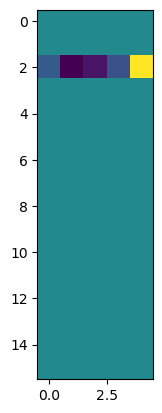

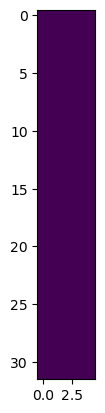

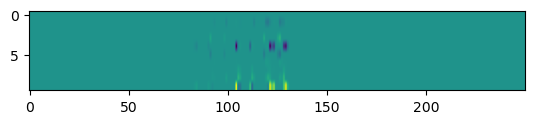

In [65]:
model.zero_grad()
out = model(torch.tensor(X_train[samp].reshape(8,1,28,28)).float())
out.retain_grad()
loss = loss_fn(out, torch.tensor(Y_train[samp]))
loss.retain_grad()
loss.backward()
imshow(model.conv1.weight.grad[:,0,:,0])
figure()
imshow(model.conv2.weight.grad[:,0,:,0])
figure()
imshow(model.ln.weight.grad[:,750:1000],aspect = 4)

In [66]:
torch_out = model(torch.tensor(X_train[samp].reshape(8,1,28,28)).float())
np.sum(np.abs(np_out-torch_out.detach().numpy()))

6.331559315686519e-05

In [67]:
np.sum(np.abs(np_out-torch_out.detach().numpy()))

6.331559315686519e-05

In [68]:
loss_fn(torch_out, torch.tensor(Y_train[samp]))

tensor(0.0090, grad_fn=<NllLossBackward0>)

In [69]:
loss

tensor(0.0090, grad_fn=<NllLossBackward0>)

In [70]:
d_conv2_weights.shape

(32, 16, 5, 5)

### Correct gradient for weights of Linear FFW

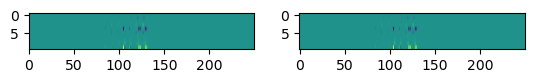

In [71]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(model.ln.weight.grad[:,750:1000], aspect = 4)
axarr[1].imshow(d_ln.T[:,750:1000],aspect = 4)


## We see that gradients for convolution layers aren't exactly as in torch but close enough.

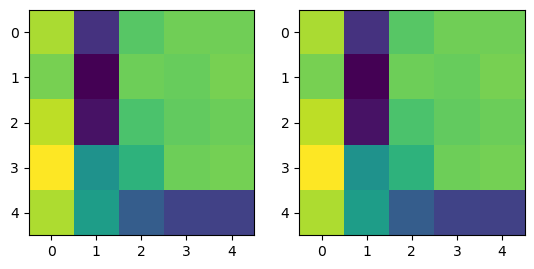

In [87]:

f, axarr = plt.subplots(1,2)
axarr[0].imshow(d_conv2_weights[12,2,:,:])
axarr[1].imshow(model.conv2.weight.grad[12,2,:,:])
    


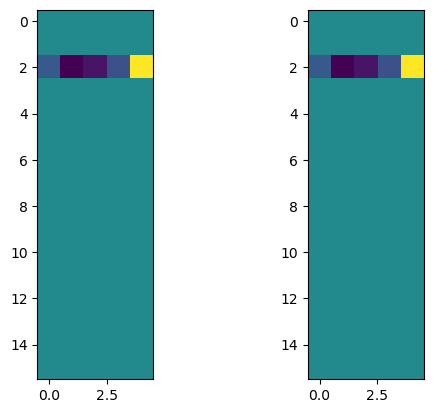

In [73]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(d_conv1_weights[:,0,:,0])
axarr[1].imshow(model.conv1.weight.grad[:,0,:,0])


In [88]:
np.sum(np.abs(d_conv1_weights - model.conv1.weight.grad.detach().numpy()))

0.018597898848499175

In [89]:
np.sum(np.abs(d_conv2_weights - model.conv2.weight.grad.detach().numpy()))

3.958995232601016e-06

loss 0.14 accuracy 0.96: 100%|███████████████████████████████████████████████████████| 300/300 [38:09<00:00,  7.63s/it]


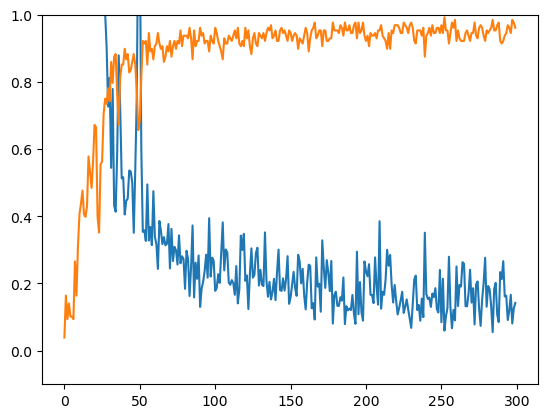

In [90]:
import gc
def conv_init_uniform(n_in_channel,kernel_size,n_out_channel):
    stdv = n_in_channel * kernel_size**2
    return np.random.uniform(-1.,1.,size = (n_out_channel,n_in_channel,kernel_size,kernel_size))/np.sqrt(stdv)
def layer_init_uniform(m,n):
    return np.random.uniform(-1.,1.,size = (m,n))/np.sqrt(m*n)

                             
np.random.seed(100)

ln = layer_init_uniform(ln.shape[0],ln.shape[1])
conv1 = conv_init_uniform(1,5,16)
conv2 = conv_init_uniform(16,5,32)


lr = 0.01
BS = 128

losses,accuracies = [], []

t = trange(300)
for i in t:
    indx = np.random.randint(0,X_train.shape[0], (BS,))
    X = X_train[indx].reshape(BS,1,28,28).astype('float')
    Y= Y_train[indx]

    np_out, loss, d_ln, d_conv2_weights, d_conv1_weights = forward_backward(X,Y)
    
    
    cat = np.argmax(np_out,axis = 1)

    ln = ln - lr * d_ln.T
    conv1 = conv1 - lr * d_conv1_weights
    conv2 = conv2 - lr * d_conv2_weights

    
    accuracy = (cat == Y).mean()

    losses.append(loss)
    accuracies.append(accuracy)

    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

    gc.collect()

plt.ylim(-0.1,1)
plot(losses)
plot(accuracies)

In [91]:
out_logsoft, loss, d_ln_weights, d_conv2_weights, d_conv1_weights = forward_backward(X_test.reshape(X_test.shape[0],1,28,28),Y_test)

In [92]:
loss

0.13471354349314618

In [93]:
acc_test_from_np = (np.argmax(out_logsoft, axis = 1) == Y_test).mean()

In [94]:
print("Accuracy from testing data: ", acc_test_from_np)

Accuracy from testing data:  0.96


In [95]:
wrong_pred = X_test[np.argmax(out_logsoft, axis = 1) != Y_test]
true_val = Y_test[np.argmax(out_logsoft, axis = 1) != Y_test]

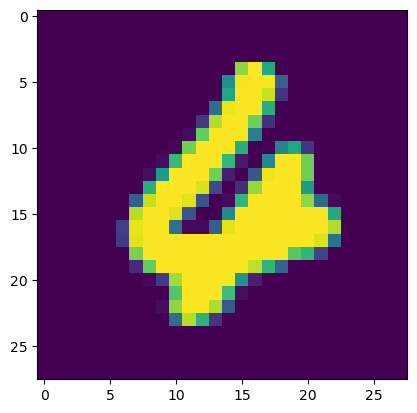

In [96]:
imshow(wrong_pred[50])

In [97]:
true_val[50]

4

In [98]:
out, _,_,_,_= forward_backward(wrong_pred[50].reshape(1,1,28,28), true_val[50].reshape(1,1))
np.argmax(out)

6

In [100]:
torch.argmax(model(torch.tensor(wrong_pred[50].reshape(1,1,28,28)).float()))

tensor(6)